In [1]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras import layers
from functools import partial

AUTO = tf.data.experimental.AUTOTUNE
import warnings
warnings.filterwarnings('ignore')

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
from glob import glob

# Change 'your-folder-path' to the actual path where your images are located in Google Drive
images = glob('/content/drive/My Drive/train_cancer/*/*.jpg')
print(len(images))


270


In [23]:

# Create a DataFrame with file paths
df = pd.DataFrame({'filepath': images})

# Extract labels and store them in a column named 'label'
df['label'] = df['filepath'].apply(lambda x: 'benign' if 'benign' in x else 'malignant')

# Display the DataFrame
print(df.head())

                                            filepath   label
0  /content/drive/My Drive/train_cancer/benign/34...  benign
1  /content/drive/My Drive/train_cancer/benign/33...  benign
2  /content/drive/My Drive/train_cancer/benign/25...  benign
3  /content/drive/My Drive/train_cancer/benign/38...  benign
4  /content/drive/My Drive/train_cancer/benign/40...  benign


In [24]:
# Count occurrences of 'benign' and 'malignant'
label_counts = df['label'].value_counts()

# Display the counts
print(label_counts)


label
malignant    240
benign        30
Name: count, dtype: int64


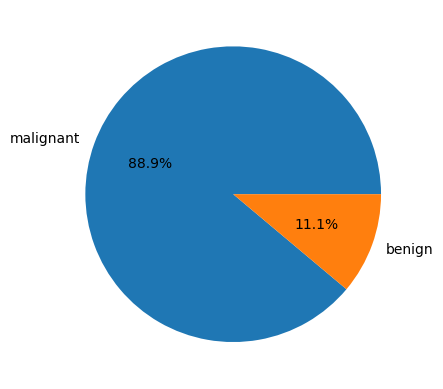

In [26]:
x = df['label'].value_counts()
plt.pie(x.values,
        labels=x.index,
        autopct='%1.1f%%')
plt.show()

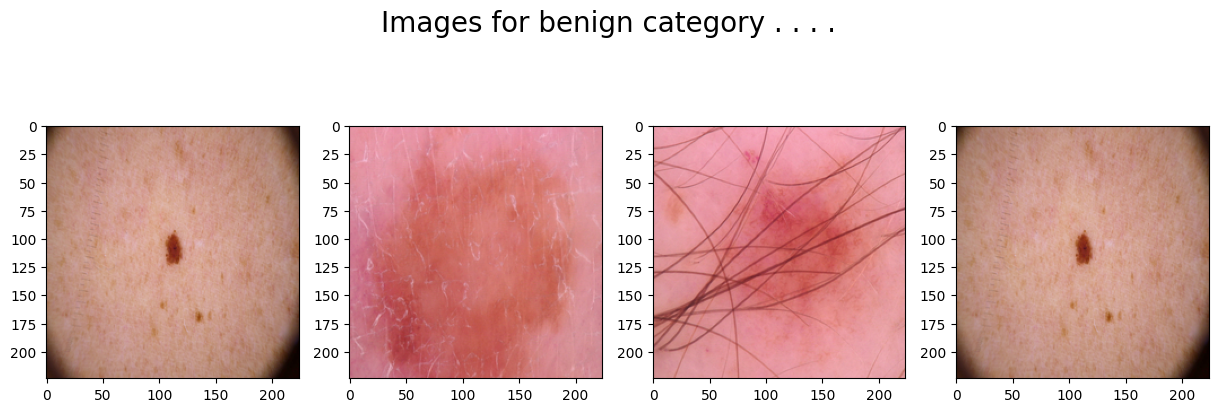

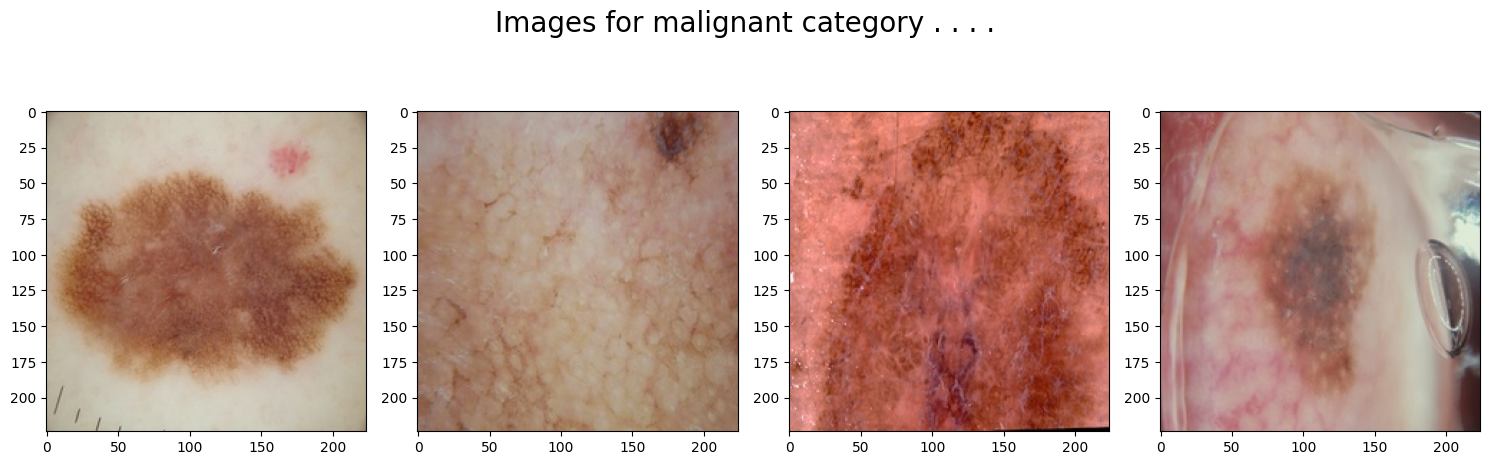

In [25]:

for cat in df['label'].unique():
    temp = df[df['label'] == cat]

    index_list = temp.index
    fig, ax = plt.subplots(1, 4, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)
    for i in range(4):
        index = np.random.randint(0, len(index_list))
        index = index_list[index]
        data = df.iloc[index]

        image_path = data[0]

        img = np.array(Image.open(image_path))
        ax[i].imshow(img)
plt.tight_layout()
plt.show()

In [27]:
features = df['filepath']
target = df['label']

X_train, X_val,\
    Y_train, Y_val = train_test_split(features, target,
                                      test_size=0.15,
                                      random_state=10)

X_train.shape, X_val.shape

((229,), (41,))

In [28]:
def decode_image(filepath, label=None):

	img = tf.io.read_file(filepath)
	img = tf.image.decode_jpeg(img)
	img = tf.image.resize(img, [224, 224])
	img = tf.cast(img, tf.float32) / 255.0

	if label == 'benign':
		Label = 0
	else:
		Label = 1

	return img, Label


In [29]:
train_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_train, Y_train))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(32)
    .prefetch(AUTO)
)

val_ds = (
    tf.data.Dataset
    .from_tensor_slices((X_val, Y_val))
    .map(decode_image, num_parallel_calls=AUTO)
    .batch(32)
    .prefetch(AUTO)
)

In [30]:
from tensorflow.keras.applications.efficientnet import EfficientNetB7

pre_trained_model = EfficientNetB7(
    input_shape=(224, 224, 3),
    weights='imagenet',
    include_top=False
)

for layer in pre_trained_model.layers:
    layer.trainable = False

258076736/258076736 [==============================] - 2s 0us/step


In [31]:

from tensorflow.keras import Model

inputs = layers.Input(shape=(224, 224, 3))
x = layers.Flatten()(inputs)

x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)

In [32]:
model.compile(
	loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
	optimizer='adam',
	metrics=['AUC']
)


In [33]:
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=5,
                    verbose=1)

Epoch 1/5
8/8 [==============================] - 51s 6s/step - loss: 0.7364 - auc: 0.7672 - val_loss: 1.6246 - val_auc: 0.5000
Epoch 2/5
8/8 [==============================] - 9s 1s/step - loss: 0.6121 - auc: 0.8411 - val_loss: 0.5454 - val_auc: 0.9392
Epoch 3/5
8/8 [==============================] - 7s 829ms/step - loss: 0.4940 - auc: 0.9344 - val_loss: 0.5147 - val_auc: 0.6520
Epoch 4/5
8/8 [==============================] - 8s 910ms/step - loss: 0.4213 - auc: 0.9630 - val_loss: 0.4082 - val_auc: 0.9358
Epoch 5/5
8/8 [==============================] - 9s 1s/step - loss: 0.3291 - auc: 0.9855 - val_loss: 0.4769 - val_auc: 0.9595


In [34]:
hist_df = pd.DataFrame(history.history)
hist_df.head()


,loss,auc,val_loss,val_auc
0,0.736442,0.767241,1.624586,0.500000
1,0.612138,0.841133,0.545436,0.939189
2,0.493973,0.934350,0.514675,0.652027
3,0.421280,0.962960,0.408248,0.935811
4,0.329087,0.985506,0.476933,0.959459


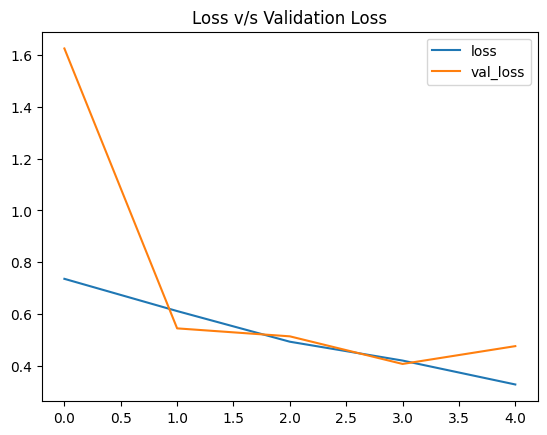

In [35]:
hist_df['loss'].plot()
hist_df['val_loss'].plot()
plt.title('Loss v/s Validation Loss')
plt.legend()
plt.show()


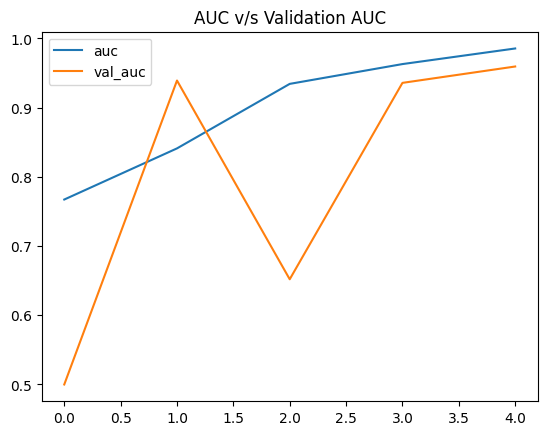

In [36]:
hist_df['auc'].plot()
hist_df['val_auc'].plot()
plt.title('AUC v/s Validation AUC')
plt.legend()
plt.show()
